Mount Google Disk into Colab.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Import all required libraries and set the constants.

In [0]:
import os
import sys
import random
import warnings
import zipfile

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
smooth = 1.
epochs = 50

Using TensorFlow backend.


Try to make folders and unzip archives with train and test data.

In [0]:
try:
    os.mkdir('stage1_train')
except Exception:
    print(Exception)
with zipfile.ZipFile('gdrive/My Drive/Colab Notebooks/stage1_train.zip', 'r') as zip_train:
    zip_train.extractall('stage1_train')
try:
    os.mkdir('stage1_test')
except Exception:
    print(Exception)
with zipfile.ZipFile('gdrive/My Drive/Colab Notebooks/stage1_test.zip', 'r') as zip_test:
    zip_test.extractall('stage1_test')

Get IDs of train and test images.

In [0]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

Functions that load train and test data from path or get the data from images if data doesn't exist yet and save it.

In [0]:
def read_train_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    if (os.path.isfile('gdrive/My Drive/Colab Notebooks/X_train.npy') and 
        os.path.isfile('gdrive/My Drive/Colab Notebooks/Y_train.npy')):

        X_train = np.load('gdrive/My Drive/Colab Notebooks/X_train.npy')
        Y_train = np.load('gdrive/My Drive/Colab Notebooks/Y_train.npy')
        print('load')
        return X_train, Y_train

    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                        preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask
    np.save('gdrive/My Drive/Colab Notebooks/X_train.npy', X_train)
    np.save('gdrive/My Drive/Colab Notebooks/Y_train.npy', Y_train)
    return X_train, Y_train

    # Get and resize test images
def read_test_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    if (os.path.isfile('gdrive/My Drive/Colab Notebooks/X_test.npy') and
        os.path.isfile('gdrive/My Drive/Colab Notebooks/sizes_test.npy')):
        X_test = np.load('gdrive/My Drive/Colab Notebooks/X_test.npy')
        sizes_test = np.load('gdrive/My Drive/Colab Notebooks/sizes_test.npy')
        print('load')
        return X_test, sizes_test
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    print('Getting and resizing test images ... ')
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img

    print('Done!')
    np.save('gdrive/My Drive/Colab Notebooks/X_test.npy', X_test)
    np.save('gdrive/My Drive/Colab Notebooks/sizes_test.npy', sizes_test)
    return X_test, sizes_test

Functions of dice metric.

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Loss funtion
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [0]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(sizes_test)

(670, 256, 256, 3)
(670, 256, 256, 1)
(65, 256, 256, 3)
65
[[512 640]
 [512 640]
 [256 256]
 [512 640]
 [256 256]
 [256 256]
 [256 256]
 [520 696]
 [512 680]
 [519 253]
 [256 256]
 [260 347]
 [512 640]
 [519 161]
 [256 256]
 [524 348]
 [256 256]
 [260 347]
 [520 348]
 [256 256]
 [512 680]
 [524 348]
 [524 348]
 [524 348]
 [256 256]
 [512 680]
 [520 348]
 [512 680]
 [520 348]
 [390 239]
 [256 256]
 [520 696]
 [520 348]
 [256 256]
 [512 680]
 [520 696]
 [512 640]
 [256 256]
 [256 256]
 [256 256]
 [256 256]
 [512 680]
 [512 640]
 [256 256]
 [256 256]
 [519 161]
 [512 640]
 [256 256]
 [260 347]
 [512 680]
 [519 162]
 [512 680]
 [256 256]
 [519 162]
 [256 256]
 [519 253]
 [256 256]
 [256 256]
 [519 253]
 [256 256]
 [256 256]
 [519 253]
 [520 696]
 [260 347]
 [512 640]]


Save the data.

In [0]:
np.save('gdrive/My Drive/Colab Notebooks/X_train.npy', X_train)
np.save('gdrive/My Drive/Colab Notebooks/Y_train.npy', Y_train)
np.save('gdrive/My Drive/Colab Notebooks/X_test.npy', X_test)
np.save('gdrive/My Drive/Colab Notebooks/sizes_test.npy', sizes_test)

Load the data.

In [0]:
X_train = np.load('gdrive/My Drive/Colab Notebooks/X_train.npy')
Y_train = np.load('gdrive/My Drive/Colab Notebooks/Y_train.npy')
X_test = np.load('gdrive/My Drive/Colab Notebooks/X_test.npy')
sizes_test = np.load('gdrive/My Drive/Colab Notebooks/sizes_test.npy')

A random example of train data.

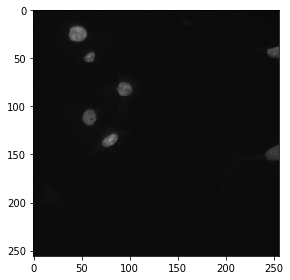

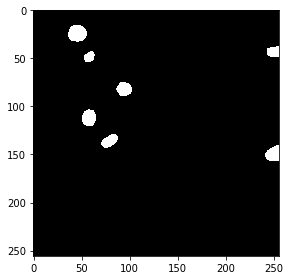

In [0]:
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

Function that returns UNET model.

In [0]:
def get_unet(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    return model

Read the data.

In [0]:
X_train, Y_train = read_train_data()
X_test, sizes_test = read_test_data()

load
load


Get the model.

In [0]:
u_net = get_unet()

Fit, save and stop fitting the model.

In [0]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('gdrive/My Drive/Colab Notebooks/model-dsbowl2018-3.h5', verbose=1, save_best_only=True)
results = u_net.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 432s 717ms/step - loss: 0.3529 - dice_coef: 0.3849 - val_loss: 0.1634 - val_dice_coef: 0.7206

Epoch 00001: val_loss improved from inf to 0.16338, saving model to gdrive/My Drive/Colab Notebooks/model-dsbowl2018-3.h5
Epoch 2/50
603/603 [==============================] - 420s 696ms/step - loss: 0.1460 - dice_coef: 0.7347 - val_loss: 0.1397 - val_dice_coef: 0.7880

Epoch 00002: val_loss improved from 0.16338 to 0.13969, saving model to gdrive/My Drive/Colab Notebooks/model-dsbowl2018-3.h5
Epoch 3/50
603/603 [==============================] - 419s 695ms/step - loss: 0.1190 - dice_coef: 0.7821 - val_loss: 0.1529 - val_dice_coef: 0.7361

Epoch 00003: val_loss did not improve from 0.13969
Epoch 4/50
603/603 [==============================] - 419s 695ms/step - loss: 0.0990 - dice_coef: 0.8195 - val_loss: 0.0882 - val_dice_coef: 0.8477

Epoch 00004: val_loss improved from 0.13969 to 0.08816, savi

Load the model and make predictions on train and test data.

In [0]:
u_net = load_model('gdrive/My Drive/Colab Notebooks/model-dsbowl2018-3.h5', custom_objects={'dice_coef': dice_coef})
preds_train = u_net.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = u_net.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = u_net.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


65/65 [==============================] - 10s 159ms/step


Show a random example of the train data and predictions.

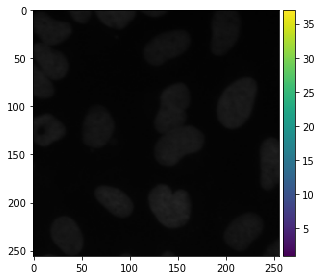

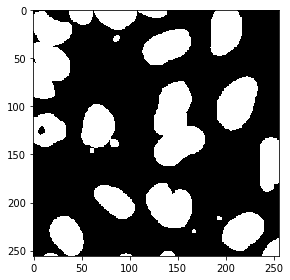

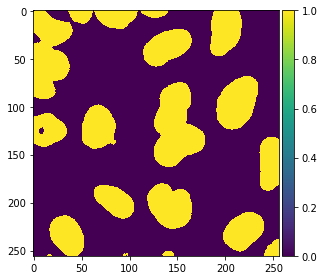

In [0]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

Show a random example of the validation data.

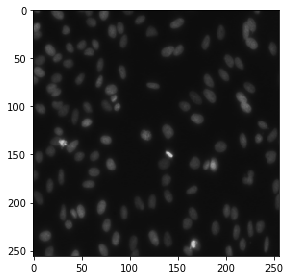

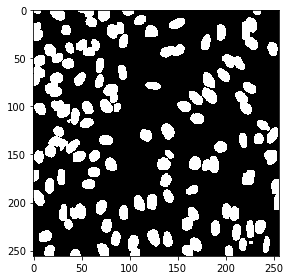

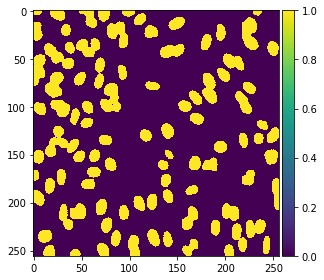

In [0]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [0]:
print(preds_train_t.shape)
print(preds_val_t.shape)
print(preds_test_t.shape)


(603, 256, 256, 1)
(67, 256, 256, 1)
(65, 256, 256, 1)


Evaluate model on the all train (train&validation) data.

In [0]:
test_loss, test_acc = u_net.evaluate(X_train, Y_train)
print(test_acc)

670/670 [==============================] - 107s 160ms/step
0.8702985868525149


Save results.

In [0]:
a = np.vstack((preds_train_t, preds_val_t))
np.save('gdrive/My Drive/Colab Notebooks/train_preds.npy', a)
np.save('gdrive/My Drive/Colab Notebooks/test_preds.npy', preds_test_t)
np.save('gdrive/My Drive/Colab Notebooks/preds_test_upsampled.npy', preds_test_upsampled)